# Test notebook

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import folium
import streamlit as st
import os
import matplotlib
from rasterstats import zonal_stats
import rasterio
import requests

from src.config_parameters import params
from src.utils import *
from src.utils_proximity import *
from src.utils_population import *
from src.utils_plotting import *

## General parameters

In [14]:
verbose = True
use_default_data = True
use_local_pop_data = True

## User input

In [4]:
# Parameters given by the user
upload_poi_file = "test_data/mda_health_hospitals.zip"
upload_aoi_file = "test_data/mda_admn_ad0.zip" 
poi_name_col = "name"

## Process input data

In [5]:
# Create geopandas dataframes and prepare starting points
aoi_gdf = create_aoi_gpd(upload_aoi_file)
poi_gdf = create_poi_gpd(upload_poi_file)

poi_within_aoi, poi_outside_aoi = poi_v_aoi(aoi_gdf, poi_gdf)
start_points_dict, map_centre = prep_user_poi(poi_gdf, poi_name_col)

/home/daniele/Documents/MapAction/Python_projects/proximity-tool/app/src/utils_proximity.py:335: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_cent = poi_gdata.dissolve().to_crs("EPSG:4326").centroid


## Run computation

In [6]:
# Initialize ORS client
ors = ors_initialize()

In [7]:
# API call
all_isos, api_time = get_isochrones(start_points_dict, ors, mock_function=use_default_data)

2023-03-08 01:46:29.724 ERROR   fiona._env: app/test_data/mda_isochrones.geojson: No such file or directory


In [8]:
# Dissolve isochrones
diss_isoc, diss_time = dissolve_iso(all_isos)

In [9]:
# Remove overlaps from isochrones
diff_isoc, diff_time = difference_iso(diss_isoc)

In [10]:
# Fill to aoi area
diff_isoc, fill_time = fill_aoi(diff_isoc, diss_isoc, aoi_gdf)

In [12]:
# Add population analysis
diff_isoc = add_population_data(diff_isoc, use_local_tif=use_local_pop_data)

/home/daniele/miniconda3/envs/proximity-test/lib/python3.9/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


## Run computation in one function

In [15]:
diff_isoc = run_analysis(
    poi_gdf=poi_gdf, 
    poi_name_col=poi_name_col,
    aoi_gdf=aoi_gdf,
    use_default_data=use_default_data,
    add_pop_data=True,
    use_local_pop_data=use_local_pop_data,
    verbose=verbose,
    text_on_streamlit=False,
    )

/home/daniele/Documents/MapAction/Python_projects/proximity-tool/app/src/utils_proximity.py:335: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_cent = poi_gdata.dissolve().to_crs("EPSG:4326").centroid
2023-03-08 01:48:58.075 ERROR   fiona._env: app/test_data/mda_isochrones.geojson: No such file or directory


Preparing start points...
Running on 10 start points.
Starting API calls, this could take a few minutes...
Completed API calls in 0.0 seconds
Dissolving isochrones...
Completed dissolve in 0.16 seconds
Removing overlapping isochrones...
Completed overlap removal in 0.04 seconds
Filling AOI areas outside isochrones...
Filled AOI area in 0.01 seconds
Aggregate population data...
Create population summary...


## Plots

In [16]:
m = plot_isochrones(
    diff_isoc,
    poi_gdf=poi_gdf, 
    poi_name_col=poi_name_col,
    add_legend=True
)
m

/home/daniele/Documents/MapAction/Python_projects/proximity-tool/app/src/utils_plotting.py:191: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.y.mean(),
/home/daniele/Documents/MapAction/Python_projects/proximity-tool/app/src/utils_plotting.py:192: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.x.mean(),


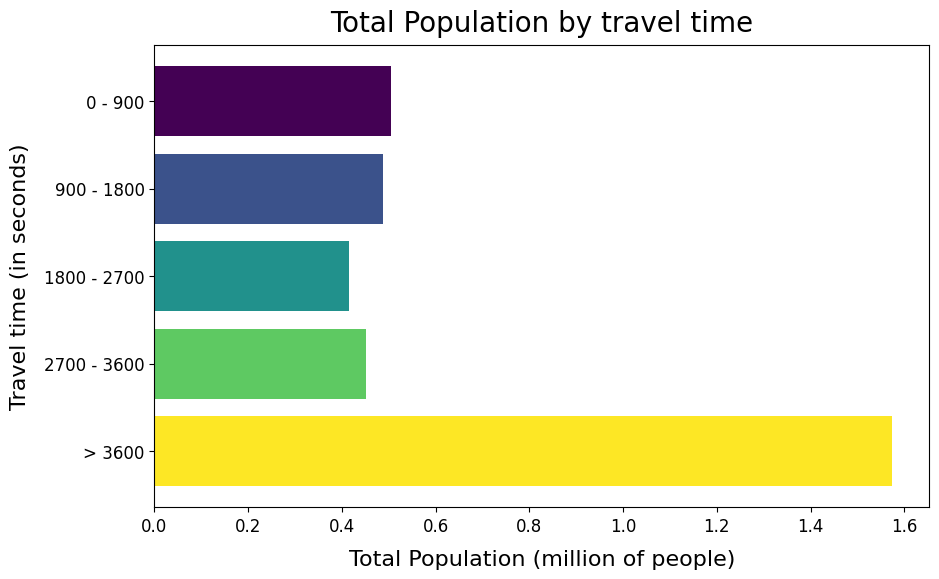

In [17]:
fig = plot_population_summary(diff_isoc)

## Additional api urls for WorldPop data retrevial

In [ ]:
# api_url = f'https://api.worldpop.org/v1/wopr/polytotal?iso3={iso3}&ver=1.2&geojson={geoj}'
# api_url = f'https://api.worldpop.org/v1/services/sample?dataset=wpgppop&year=2020&geojson={geoj}'